# Aquifer Storage and Recovery with MODFLOW6
David Haasnoot, Justin van Beek

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp
import glob
import imageio
import IPython
from tqdm import tqdm
import warnings
import datetime
warnings.simplefilter(action='ignore', category=DeprecationWarning) # for tqdm in this install package
import xarray as xr

## Description of the flow problem
Consider radial flow in a confined aquifer. The aquifer extends in the $r$ direction from $r=0$ to $r=R$, where $R$ is chosen far enough away not to effect the solution.  Water is injected by the well at a rate $Q$. The head is fixed at $r=R$ to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$ and last for $t_\text{in}$ days, after which water is extracted at the same rate $Q$ for $t_\text{out}$ days.

The parameter block is similar to the parameter block for one-dimensional (linear) flow. Some values are chosen differently, such as the time of injection. The values of the hydraulic conductivity and porosity are converted so that MODFLOW can be used to simulate radial flow (see Langevin, 2008).

In [31]:
Q_d = 40_000
Q_tot = Q_d * 1.25 ## Change this later as we actually want to produce this, currentlty we still have 80% loss
d_extrating = 62
d_injecting = 365 - d_extrating ## change later for days with water excess
print(f'Need to pump {Q_tot/d_extrating:.2f}m^3/d to full fill demand') 

Need to pump 806.45m^3/d to full fill demand


In [32]:
# Q_tot = 500
# Q = 500
# Q_in = 500
# d_extrating = 30
# d_injecting = 30

In [33]:
Q_tot/d_extrating/24

33.60215053763441

In [34]:
Q_tot

50000.0

In [35]:
# domain size and boundary conditions
R = 80 # length of domain, m
hR = 0 # head at r=R
hL = hR

# aquifer parameters
k = 20 # hydraulic conductivity, m/d -> ############ 10! 
H = 20 # aquifer thickness, m - fixed
npor = 0.35 # porosity, generally 0.25 - 0.5  ############# 0.25

# flow
Q = Q_tot/d_extrating # extraction rate, m^3/d 
Q_in = Q_tot / (d_injecting)# injection rate m^3/d

# transport
alphaL = 0.5 # longitudinal dispersivity in horizontal direction, m - ###################### something to check!! -> slides guest lecture
alphaT = alphaL / 10 # transverse dispersivity in horizontal direction, m
diffusion_coef = 0 # diffusion coeffcient

# concentration
cs = 30 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# buoyancy
rhoref = 1000 # reference density, kg/m^3
cref = 0 # reference concentration, kg/m^3
drhodc = 0.7143  # Slope of the density-concentration line

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
nlay = 30
z = np.linspace(0, -H, nlay + 1) # top and bottom(s) of layers
zc = 0.5 * (z[:-1] + z[1:]) # center so cells, used for contouring
nrow = 1 # number of rows
ncol = round(R / delr) # number of columns

# radialize parameters:
theta = 2 * np.pi
r = np.cumsum(delr * np.ones(ncol)) - 0.5 * delr # rightside of cell minus half the cell length
krad = k * r * theta * np.ones((nlay, nrow, ncol))
nporrad = npor * r * theta * np.ones((nlay, nrow, ncol))
# time discretization
########## injection
tin = d_injecting # injection time, d - rest of the year - maybe change later
delt = 0.1 # time step, d
nstepin = round(tin / delt) # computed number of steps during injection, integer

######### extraction
tout = d_extrating # extraction time, d
delt = 0.1 # time step, d
nstepout = round(tout / delt) # computed number of steps during extraction, integer

# model name and workspace
modelname = 'modelrad_kh10' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used

## Create Simulation

In [36]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # absolute path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=2, # number of stress periods 
                          perioddata=[[tin, nstepin, 1],
                                      [tout, nstepout, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
<!-- Changes in the groundwater flow model:
* Use the converted value of $k$ in the npf package and use the logarithmic averaging option to compute cell-by-cell hydraulic conductivities.
* Use the discharge $Q$ in the well package. -->

In [37]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                             inner_dvclose=1e-6
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=krad, # horizontal k value
                                k33=krad / 10,
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = []
wellout = []
for ilay in range(nlay):
    wellin.append([(ilay, 0, 0),  Q / nlay, cf])  # [(layer, row, col), U, concentration]
    wellout.append([(ilay, 0, 0),  -Q / nlay, cf]) # specified concentration is not used, but must be specified 
wel_spd = {0: wellin, 1: wellout} # stress period data for periods 0 and 1
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd = []
for ilay in range(nlay):
    chd.append([(ilay,  0,  ncol-1), hL, cs]) # [(layer, row, col), head, concentration]
chd_spd  = {0: chd, 1: chd}    # Stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )

# buoyancy
buy = fp.mf6.ModflowGwfbuy(model=gwf,
                           packagedata=[0, drhodc, cref, gwtname, 'CONCENTRATION'], # [conc 1 species - 0= salt, drhodc, cref, gwtname, name]
                           denseref=rhoref, # reference concentration
                           nrhospecies=1, # number of species
                           density_filerecord=f"{gwf.name}.dst", # file name
                           pname='BUY1', 
                          )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
<!-- Changes in the transport model: Use the converted value of the porosity in the mst package. -->

In [38]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim,
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                             inner_dvclose=1e-6
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, 
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=nporrad, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")]
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD",  # use Total Variation Diminishing (TVD)
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL,
                           ath1=alphaT, 
                           diffc=diffusion_coef,
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

In [39]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name , 
                     exgmnameb=gwt.name , 
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model

In [40]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read concentration data

<!-- Plot the concentration vs. $r$ at 10 day intervals. Make separate plots for the injection and extraction periods. -->

In [41]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file
times = np.array(cobj.get_times()) # get the times and convert to array

In [42]:
t_end_index = len(times)
t_begin_index = int(0.9*len(times))

In [43]:
# # plot concentration vs. x for three different times   
# fname = rf"figures/concentration_over_time_kh{k}.png"
# plt.figure(figsize=(10, 3))
# plt.suptitle(f"kh={k}m/d")
# plt.subplot(121)
# for t in np.arange(10, 31, 10):
#     itime = np.abs(times - t).argmin() # find index of value in times closest to t
#     plt.plot(r, c[itime,:], label=f't={times[itime]:.0f} d')
# plt.title('injection')
# plt.xlabel('r (m)')
# plt.ylabel('concentration (g/L)')
# plt.xlim(0, 40)
# plt.legend()
# plt.grid()

# plt.subplot(122)
# for t in np.arange(300, 365, 10):
#     itime = np.abs(times - t).argmin() # find index of value in times closest to t
#     plt.plot(r, c[itime,:], label=f't={times[itime]:.0f} d')
# plt.title('extraction')
# plt.xlabel('r (m)')
# plt.ylabel('concentration (g/L)')
# plt.xlim(0, 80)
# plt.legend(bbox_to_anchor=(1,0.85))
# plt.grid()
# plt.savefig(fname,bbox_inches="tight")

## Recovery efficiency
The recovery efficiency is computed using $c_\text{limit}=1$ kg/m$^3$ (g/L) as follows

In [44]:
climit = 1 # limit concentration, g/L
t_begin_index = nstepin
t_end_index = len(times)

In [45]:
for itime in range(t_begin_index, t_end_index):
    if c[itime,:, 0].mean() > climit:
        break
print(f'first time when c exceeds climit: {round(times[itime], 2)} d when concentration is {c[itime,:, 0].mean():.2f} g/L')

if t_end_index == times[itime]:
    print(f'recovery efficiency = 100%')
else:
    rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q_in) #Q  needed as injection and extraction rates are not the same
    print(f'recovery efficiency = {rec_eff * 100:.1f} %')

first time when c exceeds climit: 359.2 d when concentration is 1.00 g/L
recovery efficiency = 90.5 %


In [46]:
from ipywidgets import interact
import warnings
warnings.simplefilter("ignore")
def contour(tstep):
    plt.subplot(111, xlim=(0, 50), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
    plt.contour(r, zc, c[tstep], np.arange(5, 35, 5), cmap='coolwarm')

interact(contour, tstep=(0, nstepin + nstepout - 1, 1));

interactive(children=(IntSlider(value=1824, description='tstep', max=3649), Output()), _dom_classes=('widget-i…

### Compute the recovery efficiency for many  cycles

In [47]:
from flopy.mf6.mfbase import VerbosityLevel
sim.simulation_data.verbosity_level = VerbosityLevel.quiet

In [48]:
run = True # takes long
if run: 
    time_break_lst = []
    rec_eff_lst = []
    n_years = 3
    cycle_n = np.arange(0, n_years,1)
    c_arr = np.zeros((len(cycle_n)+1,nlay, ncol))
    c_store_all = np.zeros((len(cycle_n), nstepin+nstepout,nlay,ncol))
    c_arr[0] = np.ones((nlay,ncol)) * cs
    c_prev = cs
    for index_cycle in tqdm(cycle_n):
        # initial condition from prev time period
        gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                                     strt=c_arr[index_cycle], # initial concentration
                                     ) 
        # here also change the injection after the first two years. 
    
        
        # write model, solve model, and read concentration data
        sim.write_simulation(silent=True)
        success, _ = sim.run_simulation(silent=True) 
        if success == 1:
            # print(f'Model solved successfully for {index_cycle}', end="\r")
            pass
        else:
            print('Solve failed')
            break
        
        cobj = gwt.output.concentration() # get handle to binary concentration file
        c_i = cobj.get_alldata().squeeze() # get the concentration data from the file
        for itime in range(t_begin_index, t_end_index):
            if c_i[itime,:, 0].mean() > climit:
                time_break_lst.append(itime)
                break
    
        c_arr[index_cycle+1] = c_i[itime - 1,:]
        c_store_all[index_cycle] = c_i
        rec_eff = ((times[itime - 1] - tin) * Q) / (tin * Q_in) # Q  needed as injection and extraction rates are not the same
        rec_eff_lst.append(rec_eff*100)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [23:34<00:00, 471.65s/it]


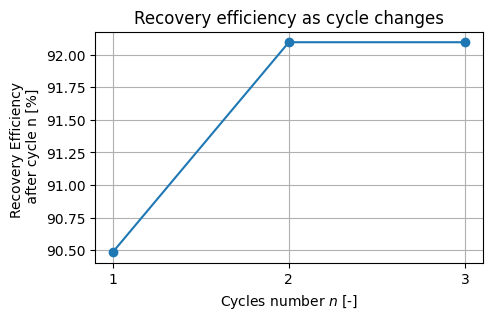

In [49]:
fname = fr"figures/recovery_eff_cycles_khk_npor{npor}.png"
if run: 
    cycle_n_arr = np.array(cycle_n) + 1
    plt.plot(cycle_n_arr,rec_eff_lst,marker="o")
    plt.ylabel("Recovery Efficiency \n after cycle n [%]")
    plt.xlabel(r"Cycles number $n$ [-]")
    plt.title(r"Recovery efficiency as cycle changes")
    plt.xticks(ticks=cycle_n_arr)
    plt.grid()
    plt.savefig(fname,bbox_inches="tight")
else: 
    img = matplotlib.image.imread(fname)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis("off")

In [50]:
# fname = rf"figures/recovery_Q_cycles_kh{k}_npor{npor}.png"
# if run: 
#     cycle_n_arr = np.array(cycle_n) + 1
#     rec_eff_arr = np.array(rec_eff_lst)
#     plt.plot(cycle_n_arr,rec_eff_arr*Q_tot/100,marker="o")
#     plt.axhline(Q_d,ls="--",color="C1",label="Design production volume")
#     plt.ylabel("Recovery Volume [m^3]")
#     plt.xlabel(r"Years after starting")
#     plt.title(f"Recovery efficiency as cycle changes\nkh={k}m/d, porosity={npor}")
#     plt.xticks(ticks=cycle_n_arr)
#     plt.grid()
#     plt.savefig(fname,bbox_inches="tight")
# else: 
#     img = matplotlib.image.imread(fname)
#     fig, ax = plt.subplots()
#     ax.imshow(img)
#     ax.axis("off")

In [51]:
n_years = 10

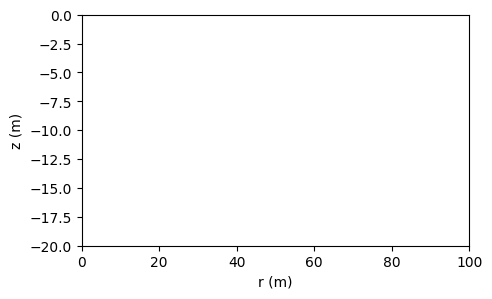

interactive(children=(IntSlider(value=1824, description='tstep', max=3649), IntSlider(value=4, description='ye…

In [52]:
from ipywidgets import interact
import warnings
warnings.simplefilter("ignore")
def contour(tstep,year):
    plt.subplot(111, xlim=(0, 100), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
    cls = plt.contour(r, zc, c_store_all[year][tstep], np.arange(5, 35, 5), cmap='coolwarm')
    plt.clabel(cls, cls.levels[::2], inline=True, fontsize=10)
 
interact(contour, tstep=(0, nstepin + nstepout - 1, 1),year=(0,n_years-1,1));

In [ ]:
# time = str(datetime.datetime.now())[:-10].replace(":","_")
# fname = fr'output/store_concentrations_k-{k}_npor-{npor}_alphaL-{alphaL}-nlay-{nlay}_{time}.nc'

In [ ]:
# ds = xr.DataArray(c_store_all,dims=['year','tstep','layer','r'])

In [ ]:
# ds.to_netcdf(fname,engine="netcdf4")

In [ ]:
# ds_in = xr.load_dataarray(fname)

In [ ]:
# data = ds_in.isel(year=0,tstep=-1)
# plt.subplot(111, xlim=(0, 100), ylim=(-20, 0), xlabel='r (m)', ylabel='z (m)')
# cls = plt.contour(r, zc, data, np.arange(5, 35, 5), cmap='coolwarm')
# plt.clabel(cls, cls.levels[::2], inline=True, fontsize=10)